<a href="https://colab.research.google.com/github/Matthew-D-Chan/Stock-Predictor-LTBR-/blob/main/my_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
# Preprocessing data | Importing, cleaning, manipulating data (Dropping, Regrouping, Aggregating, Imputing, OneHotencoding, etc.)
ticker = yf.Ticker("LTBR")
ltbr_data = ticker.history(period='max') # #mo, #y, #d, interval can be day, minute, hour
ltbr_data = ltbr_data.drop('Dividends', axis=1)
ltbr_data = ltbr_data.drop('Stock Splits', axis=1)

In [ ]:
# Table of ltbr
ltbr_data


,Open,High,Low,Close,Volume
Date,,,,,
2005-01-03 00:00:00-05:00,234.00,252.00,234.0000,234.00,35
2005-01-04 00:00:00-05:00,234.00,252.00,234.0000,234.00,326
2005-01-05 00:00:00-05:00,234.00,270.00,216.0000,270.00,213
2005-01-06 00:00:00-05:00,270.00,270.00,252.0000,270.00,631
2005-01-07 00:00:00-05:00,288.00,306.00,270.0000,270.00,766
...,...,...,...,...,...
2025-08-05 00:00:00-04:00,14.26,14.96,13.7700,14.27,1168700
2025-08-06 00:00:00-04:00,14.31,14.98,14.3100,14.66,1036300
2025-08-07 00:00:00-04:00,14.75,14.87,13.4800,14.07,1002700


<Axes: title={'center': 'Lightbridge Corporation'}, xlabel='Date', ylabel='Price ($)'>

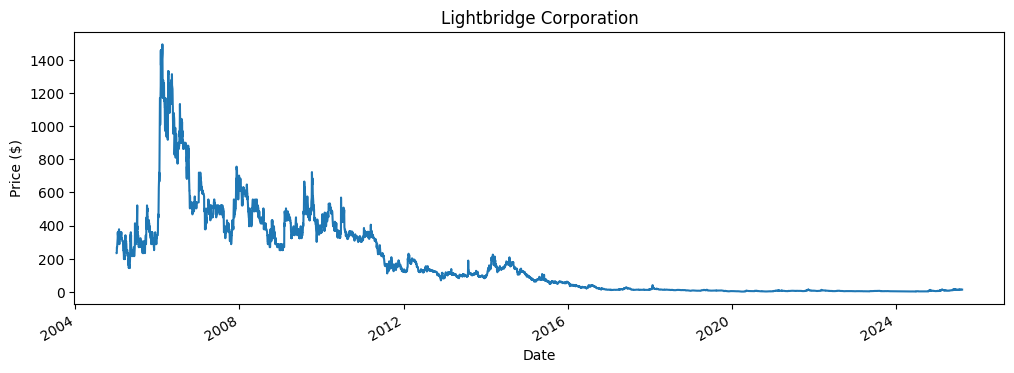

In [ ]:
# Graph of ltbr
fig, ax = plt.subplots(figsize=(12,4))
ax.set_title("Lightbridge Corporation")
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
ltbr_data['Close'].plot(kind="line", ax=ax)

<Axes: title={'center': 'Lightbridge Corporation, 6 years'}, xlabel='Date', ylabel='Price ($)'>

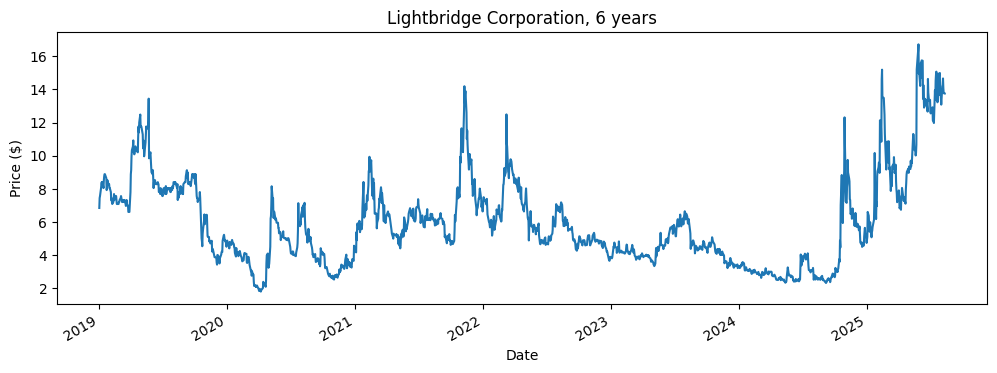

In [ ]:
# Graph of ltbr, 6 years, the one that will be used
fig, ax = plt.subplots(figsize=(12,4))
ax.set_title("Lightbridge Corporation, 6 years")
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
ltbr_data['Close'].loc["2019-01-01":].copy().plot(kind="line", ax=ax)

In [ ]:
# Adding "Tomorrow" Column
ltbr_data['Tomorrow'] = ltbr_data['Close'].shift(-1)
# ltbr_data = ltbr_data.dropna(subset=['Tomorrow'])
ltbr_data[-5:]

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
2025-08-05 00:00:00-04:00,14.26,14.96,13.7700,14.27,1168700,14.66
2025-08-06 00:00:00-04:00,14.31,14.98,14.3100,14.66,1036300,14.07
2025-08-07 00:00:00-04:00,14.75,14.87,13.4800,14.07,1002700,13.77
2025-08-08 00:00:00-04:00,13.88,14.43,13.4200,13.77,752300,13.75
2025-08-11 00:00:00-04:00,14.00,14.40,13.6709,13.75,450693,NaN


In [ ]:
# Setting up "Target" based on Tomorrow's price. What we are trying to predict
ltbr_data['Target'] = (ltbr_data['Tomorrow'] > ltbr_data['Close']).astype(int) # 0 for no, 1 for yes
ltbr_data[-5:]

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2025-08-05 00:00:00-04:00,14.26,14.96,13.7700,14.27,1168700,14.66,1
2025-08-06 00:00:00-04:00,14.31,14.98,14.3100,14.66,1036300,14.07,0
2025-08-07 00:00:00-04:00,14.75,14.87,13.4800,14.07,1002700,13.77,0
2025-08-08 00:00:00-04:00,13.88,14.43,13.4200,13.77,752300,13.75,0
2025-08-11 00:00:00-04:00,14.00,14.40,13.6709,13.75,450693,NaN,0


In [ ]:
# Cleaning data, only taking the last 6 years of past data. 2019 and onwards
ltbr_data = ltbr_data.loc["2019-01-01":].copy()

# ML Workflow | Create a pipeline, fit/train, predict, compare validation and predictions with graph
X = ltbr_data[['Open', 'High', 'Low', 'Volume', 'Close']]
y = ltbr_data['Target']
# y.dropna(inplace=True) is not needed. The predictive variable is not a feature, and is not needed to make predictions on the feature

# Splitting data
X_train = X.iloc[:-100]
X_valid = X.iloc[-100:]
y_train = y.iloc[:-100]
y_valid = y.iloc[-100:]

# Adding new features. A variety of rolling averages.
# Taking the average of the last two days, last week, last couple months, and comparing it to the current price
# Gives the model more info on whether or not the stock is due for a downswing, upswing, etc.
horizons = [2,5,60,250]
new_predictors = []

for horizon in horizons :
    rolling_averages = ltbr_data.rolling(horizon).mean()

    # Gives a ratio of the current days price to the avg price two days ago, etc.
    ratio_column = f"Close_Ratio_{horizon}"
    ltbr_data[ratio_column] = ltbr_data["Close"] / rolling_averages["Close"]

    # Sums the past horizon amount of days' target values
    trend_column = f"Trend_{horizon}"
    ltbr_data[trend_column] = ltbr_data.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

# Drops all Nan values, except fro the ones in the "Tomorrow" column
ltbr_data = ltbr_data.dropna()

X = ltbr_data[new_predictors]

# Pipeline made and model fitted/trained
model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=0, max_depth=6) # Either 0.11 or 0.13
my_pipeline = Pipeline(steps=[('model', model)])
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

precision: 0.34782608695652173
recall: 0.16666666666666666


<Axes: xlabel='Date'>

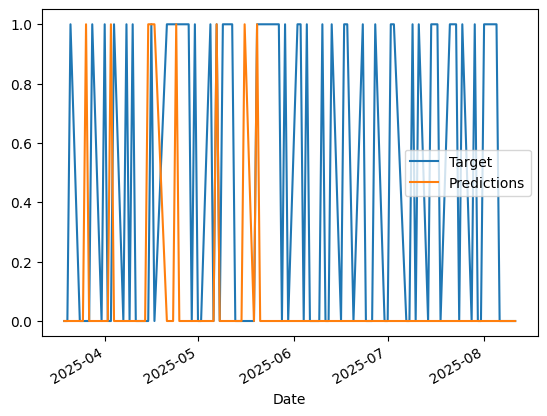

In [ ]:
# Precision and recall percentages
preds = my_pipeline.predict(X_valid) # Predict the 'unseen' validation data
preds = pd.Series(preds, index=y_valid.index)
precision = precision_score(y_valid, preds) # Compare the predictions from preds, to the actual value stored in y_valid
recall= recall_score(y_valid, preds)
print("initial precision: " + str(precision))
print("recall: " + str(recall))

# Prediction function
def predict(X_train, X_valid, y_train, y_valid, pipeline) :
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict_proba(X_valid)[:,1]
    preds[preds >= .6] = 1
    preds[preds <= .6] = 0
    preds = pd.Series(preds, index=y_valid.index, name="Predictions")
    combined = pd.concat([y_valid, preds], axis=1) # axis=1 creates side by side, column, comparison. Otherwise they would be stack on top and become one list of numbers
    return combined

# Initial_prediction
initial_prediction = predict(X_train, X_valid, y_train, y_valid, my_pipeline)
fig, ax = plt.subplots()
initial_prediction.plot(ax=ax)

In [ ]:
# Backtesting function (alternative to cross-validation, for example, to prevent data leakage)
def backtest(X, y, pipeline, start=1000, step=125) : # 3000 (6 years of trading days), 250 (1 year of trading days)
    all_predictions= []


    for i in range(start, X.shape[0], step):  # data.shape is the # of rows

        if X.shape[0] - (start + step *i) < 125 :
            step = 34

        X_train = X.iloc[0:i].copy()
        X_valid = X.iloc[i:(i+step)].copy() # Validation data is the next year
        y_train = y.iloc[0:i].copy()
        y_valid = y.iloc[i:(i+step)].copy() # Validation data is the next year
        predictions = predict(X_train, X_valid, y_train, y_valid, pipeline)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

# Running the backtest function, seeing the accuracy of the predictions if we started in the past
predictions = backtest(X, y, my_pipeline)
print(predictions['Predictions'].value_counts())
print(predictions['Predictions'])
print("accuracy of improved model: " + str(precision_score(predictions['Target'], predictions['Predictions'])))

Predictions
0.0    110
1.0     26
Name: count, dtype: int64
Date
2022-12-20 00:00:00-05:00    1.0
2022-12-21 00:00:00-05:00    0.0
2022-12-22 00:00:00-05:00    0.0
2022-12-23 00:00:00-05:00    0.0
2022-12-27 00:00:00-05:00    0.0
                            ... 
2024-08-01 00:00:00-04:00    0.0
2024-08-02 00:00:00-04:00    0.0
2024-08-05 00:00:00-04:00    0.0
2024-08-06 00:00:00-04:00    0.0
2024-08-07 00:00:00-04:00    0.0
Name: Predictions, Length: 136, dtype: float32
accuracy of improved model: 0.5384615384615384
